# Portfolio Optimization
We are going to use **mean-variance portfolio optimization (MPT)**. We want to achieve minimal portfolio risk or maximal portfolio return, through the idea of **diversification**. We are going to use all SP500 stocks, however that might not be as diverse as possible, I highly recommend to avoid that approach or make a further research.

In [2]:
import bs4 as bs
import pandas as pd
import requests
import csv
import re
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.pylab import rcParams
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import scipy.optimize as sco
#import os

### Downloading historical data
The lines below extract the SP500 codes from Wikipedia and then all the historical data from alphavantage (can work as a real-time API), however I think there is a way to extract information using pandas, for both methods, please check request interval.

In [3]:
path = 'SP500/'

In [4]:
def sp_tick(link):
    resp = requests.get(link)
    soup = bs.BeautifulSoup(resp.text)
    tab = soup.find('table', {'class' : 'wikitable sortable'})
    tickers = []
    for row in tab.findAll('tr')[1:]:
        ticker = row.findAll('td')[0]
        ticker = ticker.text
        tickers.append(ticker.replace("\n", ""))
    return(tickers)

#### The logic to keep 5 requests per minute still need to be improved
It was working in 2018 XD.

In [ ]:
#be aware that this can change and we can also use NASDAQ https://es.wikipedia.org/wiki/NASDAQ-100
link = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
#check nombres list includes what you need
codes = sp_tick(link)
#https://www.alphavantage.co/support/#api-key
cve_api = 'QTD5FWSAPAA8DHEW'
not_found = []
counter = 0
start_time = time.time()
for i in codes:
    #Bajo la idea que se busca toda la información: outputsize=full
    av = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + i +'&apikey=' + cve_api + '&datatype=csv')
    #av = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + i +'&outputsize=full&apikey=' + cve_api + '&datatype=csv')
    #Si no encuentra el titulo en el API
    if re.search('.*Error Message.*', av.text):
        #Imprime una notificación si no se encuentra
        print("WARNING: Stock: " + i + ' has not been found.')
        not_found.append(i)
    elif av.text.splitlines()[0] == "<!DOCTYPE html>":
        print("WARNING: Stock: " + i + ' has not been found.')
        not_found.append(i)
    else:
        with open((path + i +'.csv'), 'w') as l:
            writer = csv.writer(l)
            reader = csv.reader(av.text.splitlines())
            for fila in reader:
                writer.writerow(fila)
    counter += 1
    if counter > 4:
        elapsed_time = time.time() - start_time
        if elapsed_time < 55:
            time.sleep(65 - elapsed_time)
        start_time = time.time()
        counter = 0

### Create Table with all adjusted close prices from previous download cell
Previously downloaded csv's need to be in given path

In [ ]:
#codes = os.listdir(path)
all_df = pd.DataFrame()
for nombre in codes:
    #nombre = nombre[:-4]
    try:
        df = pd.read_csv(path + '{}.csv'.format(nombre))
        df.set_index('timestamp', inplace = True)
        df.rename(columns = {'adjusted_close': nombre}, inplace = True)
        all_df = all_df.join(df[[nombre]], how='outer')
    except:
        print("Warning: Stock: " + nombre + " Cannot be fine with that name")
        pass
all_df.to_csv('SP500.csv')

### Correlation heatmap between all SP500 stocks.
This can help us with our trading strategies, if we have found high correlation between two stocks and one goes down, would be good idea to sell.
<br>
Once downloaded, it would be better to run only the cells below.

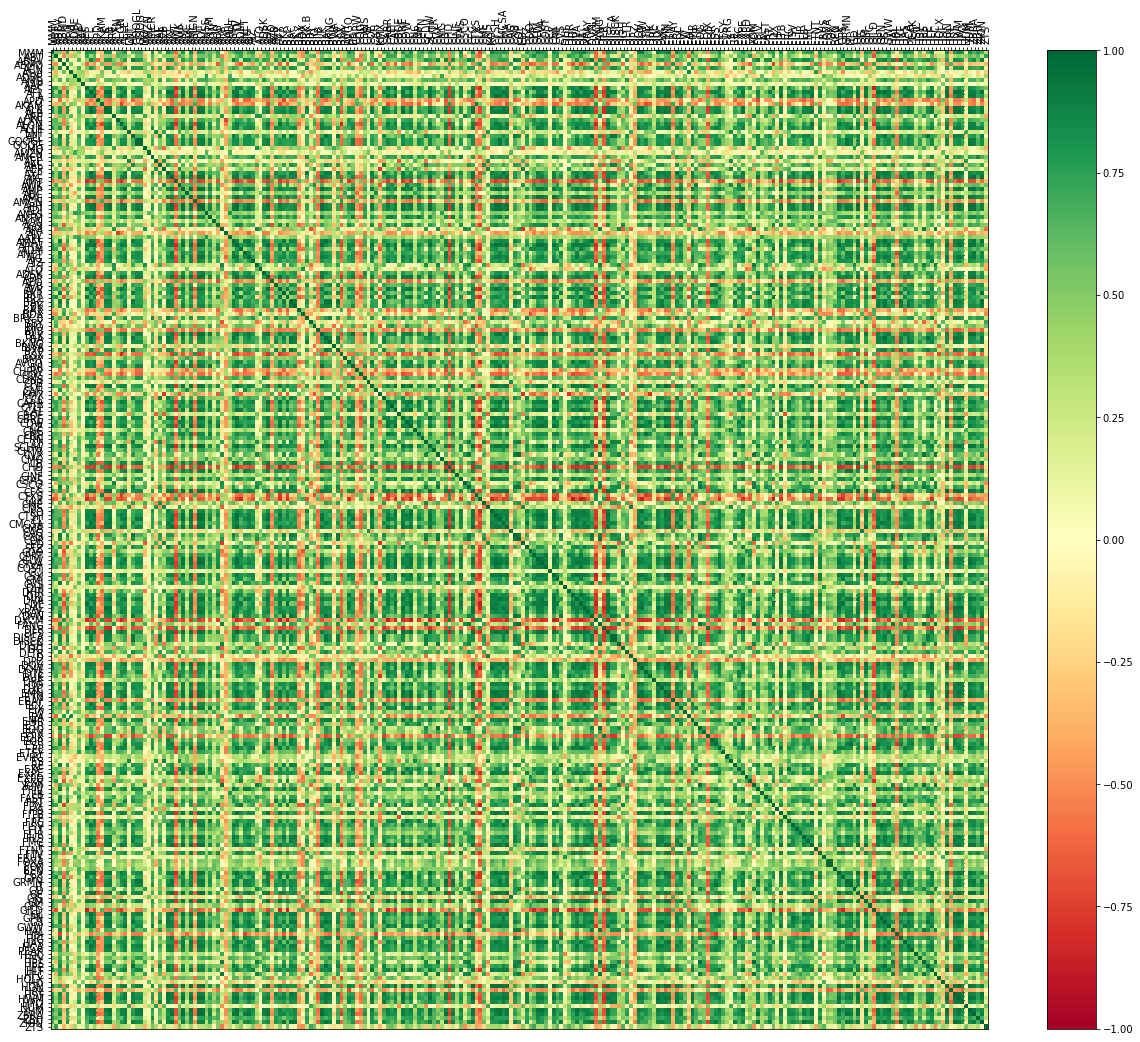

In [6]:
#will load the data again
all_df = pd.read_csv('SP500.csv', index_col = "timestamp")
rcParams["figure.figsize"]=21, 18

df_corr = all_df.corr()
values = df_corr.values
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
heatmap = ax.pcolor(values, cmap = plt.cm.RdYlGn)
fig.colorbar(heatmap)
ax.set_xticks(np.arange(values.shape[0]) + 0.5, minor = False)
ax.set_yticks(np.arange(values.shape[1]) + 0.5, minor = False)
ax.invert_yaxis()
ax.xaxis.tick_top()
columns_labels = df_corr.columns
row_labels = df_corr.index
ax.set_xticklabels(columns_labels)
ax.set_yticklabels(row_labels)
plt.xticks(rotation = 90)
heatmap.set_clim(-1, 1)
plt.tight_layout
plt.show()

In [7]:
all_df.tail()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,HRL,HST,HWM,HPQ,HUM,YUM,ZBRA,ZBH,ZION,ZTS
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-12-11,174.02,107.02,106.34,258.45,245.83,83.68,475.91,91.65,157.414561,21.15,...,47.20,14.510,26.43,23.11,391.13,105.99,377.56,141.68,41.68,159.53
2020-12-14,173.08,106.79,104.20,267.62,243.75,85.94,486.42,94.78,157.314717,21.30,...,47.20,14.030,26.81,23.21,388.23,105.50,383.46,142.59,40.71,159.50
2020-12-15,174.68,107.45,102.82,275.36,247.05,86.92,482.64,97.12,159.591168,22.28,...,47.33,14.510,26.94,23.71,392.33,107.38,383.45,147.81,41.61,161.96
2020-12-16,175.41,107.34,104.64,274.14,247.45,88.22,489.90,96.85,161.068864,21.90,...,47.22,14.415,26.83,23.98,392.76,107.42,377.41,148.85,41.87,160.62
2020-12-17,NaN,108.78,104.89,281.99,264.47,88.46,495.36,96.84,160.340000,22.09,...,47.77,14.290,26.96,24.22,396.34,108.79,375.43,151.36,41.87,162.70


In [8]:
all_df.dropna(inplace = True)

## Momentum (as rate) bigger than 0.5
#### closing[t] / closing[t-n] - 1
However there are other methods to sell or buy stocks, for example, 52 weeks high to sell.

In [9]:
((all_df.loc['2020-12-16'] / all_df.loc['2020-07-29']) - 1).loc[((all_df.loc['2020-12-16'] / all_df.loc['2020-07-29']) - 1) > 0.5]

ALB     0.630341
ALXN    0.510803
ALGN    0.719758
CBRE    0.530930
SCHW    0.530805
DAL     0.597201
DVN     0.528416
DFS     0.690170
ETSY    0.677615
FDX     0.712238
FCX     0.833835
GE      0.661288
GM      0.599846
HWM     0.757040
dtype: float64

#### I will not make further analysis on particular stocks
Since this is not a recommendation for buying or selling any particular stock. **I highly recommend make further analysis** both technical and fundamental.

In [10]:
all_df.describe()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,HRL,HST,HWM,HPQ,HUM,YUM,ZBRA,ZBH,ZION,ZTS
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,164.534248,106.270322,92.866945,280.814646,234.100819,80.521061,477.582323,83.363788,153.359351,18.963912,...,49.664491,11.996869,19.400202,19.400232,412.669520,96.979659,302.266162,141.389175,33.931896,160.746841
std,6.617496,3.769672,7.214192,17.442924,9.798441,2.866200,21.269125,5.336783,3.785180,1.760409,...,1.578754,1.537616,3.283713,1.742988,15.223934,5.546192,42.969546,5.633887,4.302294,3.963101
min,147.789086,98.730136,80.490000,251.880000,213.598074,75.120000,435.230000,74.700000,144.105313,15.009866,...,46.600000,10.190000,14.780000,16.788327,384.820964,88.949978,248.730000,130.405388,27.975982,147.405386
25%,160.434825,103.379602,86.578035,268.210000,227.758584,78.620000,462.640000,79.090000,151.191917,17.665382,...,48.641716,10.920000,17.265000,18.162435,401.270000,92.384107,275.140000,137.201696,31.180530,158.575682
50%,164.292680,106.790000,92.679387,274.100000,233.730604,80.490000,478.470000,82.610000,153.791388,18.653134,...,49.610000,11.380000,18.140000,18.983579,409.290000,95.431558,286.530000,140.277626,32.179318,160.620000
75%,169.379110,108.535000,97.875000,296.890000,241.000000,82.525000,490.635000,85.715000,156.071655,20.519793,...,50.746836,13.035000,22.320000,19.553880,422.995000,101.455146,342.905000,146.275000,37.360000,163.052949
max,177.120000,114.420000,108.670000,317.000000,253.440000,88.220000,533.800000,97.120000,162.334246,22.280000,...,52.510000,15.650000,26.940000,23.980000,452.010000,107.420000,383.460000,155.950000,44.015000,174.350000


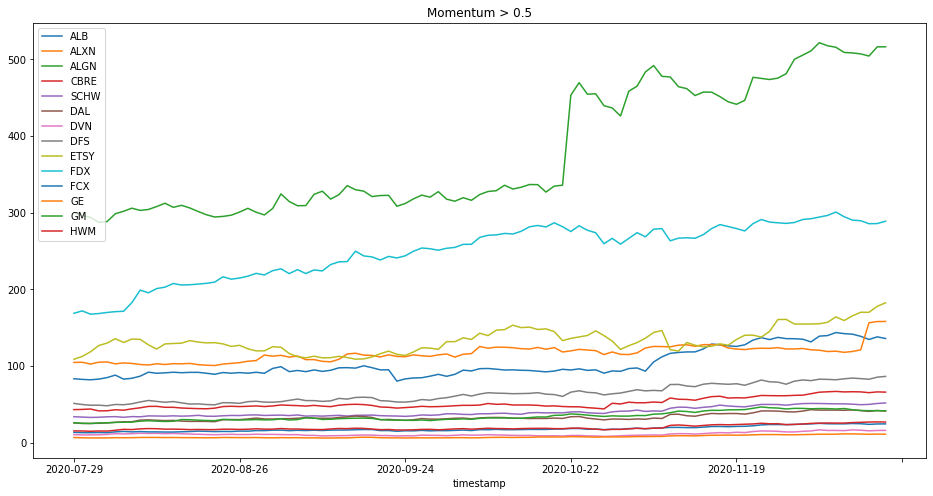

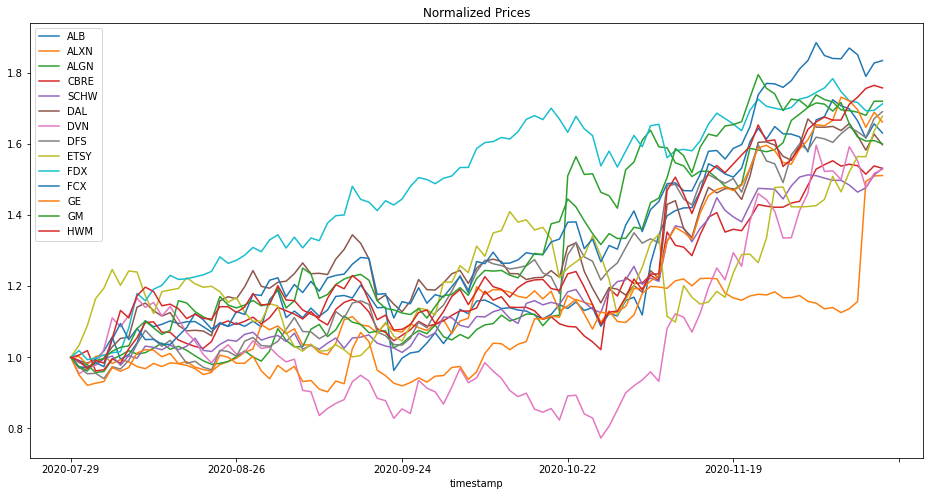

In [11]:
df = pd.DataFrame()
df = df.join(all_df[["ALB", "ALXN", "ALGN", "CBRE", "SCHW", "DAL", "DVN","DFS","ETSY", "FDX", "FCX","GE", "GM", "HWM"]], how = 'outer')
ma = df.copy()
val = ["ALB", "ALXN", "ALGN", "CBRE", "SCHW", "DAL", "DVN","DFS","ETSY", "FDX", "FCX","GE", "GM", "HWM"]
# Para los últimos dos años
df.plot(title = 'Momentum > 0.5', figsize = (16, 8))
plt.show()

#how prices have grown since first observation
(df / df.iloc[0]).plot(title = 'Normalized Prices', figsize = (16,8))
plt.show()

### Portfolio Optimization
Since we are going to use the Mean-variance of the logarithm return to estimate future values, we want to make sure that they behave normally.

In [18]:
#returns
ret = np.log(all_df / all_df.shift(1))
ret.dropna(inplace = True)

In [19]:
def normality(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
    fig.suptitle('QQ-Plot and histogram for normality: ' + data, fontsize = 16)
    sm.qqplot(ret[data].dropna(), line = 's', ax = ax1)
    plt.grid(True)
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Sample quantiles')
    ret[data].hist(bins = 50, ax = ax2)
    plt.xlabel('Log returns')
    plt.show()

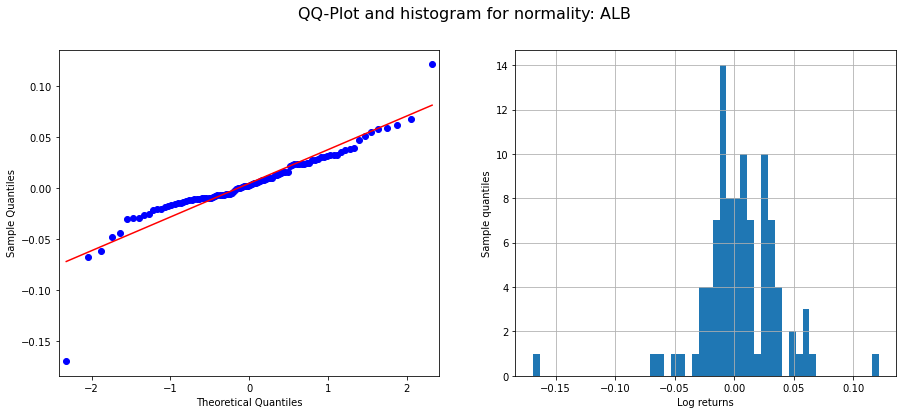

In [20]:
normality('ALB')

In [21]:
def normality_test(data):
    if len(ret[data])>2000:
        print(st.jarque_bera(ret[data]))
    print('Shapiro-Wilk test: ')  
    print(st.shapiro(ret[data].dropna()))
    print('Kolmogorov-Smirnov test: ')
    print(st.kstest(ret[data].dropna(), 'norm' ))
    print('Anderson-Darling test: ')
    print(st.anderson(ret[data].dropna(), 'norm'))

normality_test('ALB')

Shapiro-Wilk test: 
ShapiroResult(statistic=0.8896794319152832, pvalue=5.926222002017312e-07)
Kolmogorov-Smirnov test: 
KstestResult(statistic=0.4630346497032497, pvalue=9.288733640275131e-20)
Anderson-Darling test: 
AndersonResult(statistic=1.8154910203437424, critical_values=array([0.555, 0.632, 0.758, 0.884, 1.052]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


### Annualized performance

In [25]:
ret.mean() * 252

MMM     0.342637
ABT     0.126717
ABBV    0.229702
ABMD   -0.224072
ACN     0.261535
          ...   
YUM     0.344302
ZBRA    0.824790
ZBH     0.169968
ZION    0.630901
ZTS     0.220770
Length: 243, dtype: float64

### Covariance selection
Central piece of portfolio selection. 

In [27]:
ret.cov() * 252

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,HRL,HST,HWM,HPQ,HUM,YUM,ZBRA,ZBH,ZION,ZTS
MMM,0.051426,0.017358,0.014688,0.013189,0.020646,-0.010607,-0.001380,-0.013404,0.016558,0.029870,...,0.008108,0.049830,0.063757,0.033644,0.015956,0.025483,0.028861,0.027342,0.063772,-0.000490
ABT,0.017358,0.069944,0.024903,0.044178,0.025007,0.029932,0.029709,0.035205,0.006716,0.010991,...,0.018171,-0.016441,0.001881,0.015919,0.033260,0.006305,0.028122,0.013357,-0.006178,0.028714
ABBV,0.014688,0.024903,0.067336,0.022533,0.022221,0.017553,0.018596,0.015729,0.013699,0.001131,...,0.010702,0.031649,0.027735,0.019949,0.037831,0.013956,0.025943,0.025353,0.025258,0.019165
ABMD,0.013189,0.044178,0.022533,0.142597,0.027889,0.039928,0.047021,0.066065,0.019844,0.019003,...,0.012789,0.018045,0.027224,0.009813,0.039007,0.018845,0.053115,0.047472,0.017013,0.030660
ACN,0.020646,0.025007,0.022221,0.027889,0.061452,0.027132,0.044600,0.029117,0.024484,0.023547,...,0.010273,0.042810,0.042149,0.038853,0.019818,0.020104,0.043346,0.035402,0.031341,0.025805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.025483,0.006305,0.013956,0.018845,0.020104,0.003302,0.008735,0.001528,0.019027,0.028108,...,0.007391,0.066227,0.059417,0.029741,0.015866,0.048475,0.027823,0.035032,0.046995,0.010901
ZBRA,0.028861,0.028122,0.025943,0.053115,0.043346,0.032565,0.066584,0.081522,0.033581,0.022987,...,0.010364,0.044186,0.059110,0.030867,0.026586,0.027823,0.127142,0.038906,0.035785,0.033462
ZBH,0.027342,0.013357,0.025353,0.047472,0.035402,-0.008640,0.007389,0.003283,0.023884,0.032713,...,0.000614,0.138857,0.096367,0.039650,0.025765,0.035032,0.038906,0.108131,0.120330,0.006219
ZION,0.063772,-0.006178,0.025258,0.017013,0.031341,-0.066641,-0.069883,-0.041394,0.030041,0.062545,...,-0.003413,0.283743,0.208013,0.081245,0.004752,0.046995,0.035785,0.120330,0.326203,-0.038794


#### We need to give a proportion to each stock. Below random, but we can use uniform, for example.

In [29]:
sp = len(ret.columns)
proportions = np.random.random(sp)
#sum to 1
proportions /= np.sum(proportions)

#### Expected Portfolio Return

In [32]:
np.sum(ret.mean() * proportions) * 252

0.3560866139141659

#### Standard deviation or volatility

In [36]:
np.sqrt(np.dot(proportions.T, np.dot(ret.cov()*252, proportions)))

0.18299419470106926

### Monte Carlo Simulation

In [38]:
pret = []
pvol = []
for p in range(5000):
    proportions = np.random.random(sp)
    proportions /= np.sum(proportions)
    pret.append(np.sum(ret.mean() * proportions) * 252)
    pvol.append(np.sqrt(np.dot(proportions.T, np.dot(ret.cov()*252, proportions))))


pret = np.array(pret)
pvol = np.array(pvol)

### Sharpe Ratio
Is the expected excess return of a portfolio. Is the **expected return** minus **risk free** short rate divided by the **expected volatility**. We will add this as a color mark, I will say that risk free return is 3% (Please look at EDA notebook to understand just a little bit more about Sharpe ratio).

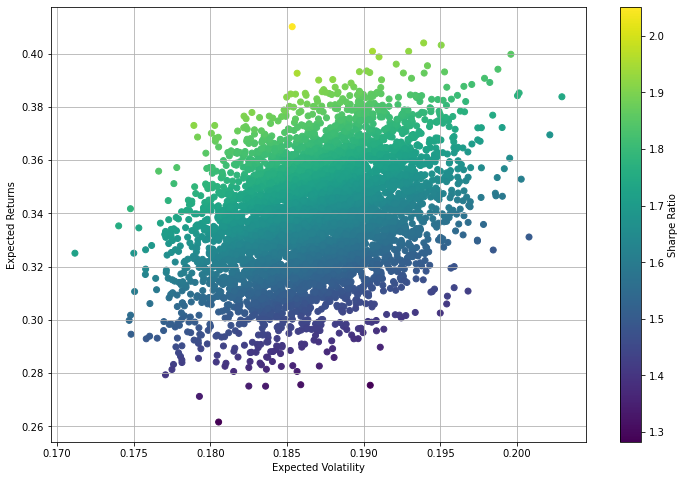

In [43]:
plt.figure(figsize=(12, 8))
plt.scatter(pvol, pret, c = (pret-0.03)/pvol, marker = 'o')
plt.grid(True)
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Returns")
plt.colorbar(label = "Sharpe Ratio")
plt.show()

### Maximizing Sharpe Ratio
Now for the next section we supose **risk free value is 0** (simplicity).

In [62]:
def portfolio_statistics(prop):
    proportions = np.array(prop)
    pret = np.sum(ret.mean() * proportions) * 252
    pvol = np.sqrt(np.dot(proportions.T, np.dot(ret.cov()*252, proportions)))
    return([pvol, pret / pvol])

#we are minimizing negative sharpe ratio, then we expect to maximize sharpe ratio
def min_func_sharpe(prop):
    return(- portfolio_statistics(prop)[1])

In [63]:
#constraint can also be written as lambda x: np.sum(x) == 1
cons = ({"type":"eq", "fun": lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(sp))
#starting values
starting = sp * [1 / sp]

In [64]:
#Sequential Least Square Programming
opts = sco.minimize(min_func_sharpe, starting, method = "SLSQP", bounds = bnds, constraints = cons)

In [65]:
opts

     fun: -5.762197860558823
     jac: array([ 2.95235240e+00,  2.43342340e+00,  7.23973274e-01,  4.64478260e+00,
        2.85958010e+00,  5.74344099e-01,  2.30207777e+00,  6.93007290e-01,
        2.32935721e+00, -4.45365906e-04,  2.77242362e+00,  9.25816298e-01,
        6.05743492e+00,  4.59873015e+00,  2.72589374e+00,  2.25513023e+00,
        2.84305096e+00,  1.09076500e-04,  2.50303745e-03,  3.80574685e+00,
        3.28792417e+00,  1.26092994e+00,  2.34996372e+00,  2.45829725e+00,
        2.68768483e+00,  3.87578112e+00,  3.90002447e+00,  2.90643895e+00,
        3.36356556e+00,  2.31680870e+00,  3.16862148e+00,  4.37205917e+00,
        5.76154405e+00,  2.60180360e+00,  3.45560235e+00,  3.92583334e+00,
        2.59813643e+00,  4.22937477e+00,  2.77215153e+00,  1.81902552e+00,
        2.91514593e+00,  2.69700402e+00,  2.83404249e+00,  4.54401726e+00,
        8.63712275e+00,  1.85114888e+01,  1.11827111e+00,  1.45478147e+00,
        1.76770896e+00,  2.73351318e+00,  2.27093935e+00,  2.

In [66]:
opts["x"].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.055, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.054,
       0.044, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.077, 0.   , 0.   ,
       0.   , 0.   , 0.064, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.114,
       0.   , 0.   , 0.047, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.02 ,
       0.   , 0.   ,

In [68]:
#sharpe ratio
portfolio_statistics(opts["x"])[1]

5.762197860558823

### Minimizing Volatility

In [69]:
def min_func_vol(prop):
    return(portfolio_statistics(prop)[0]**2)

In [70]:
opts = sco.minimize(min_func_vol, starting, method = "SLSQP", bounds = bnds, constraints = cons)

In [73]:
opts["x"].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.006, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.079, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.005, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.038, 0.181,
       0.   , 0.   , 0.008, 0.059, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.045, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.007, 0.   , 0.   , 0.   , 0.   ,
       0.077, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.035, 0.   , 0.052, 0.   , 0.   , 0.   , 0.029, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.034, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.033, 0.   ,
       0.   , 0.   ,

In [91]:
selected_stocks = np.argwhere(opts["x"].round(3))
all_df.columns[selected_stocks.reshape(1, len(selected_stocks))[0]]

Index(['ATVI', 'AEP', 'AIV', 'AIZ', 'T', 'ADP', 'AZO', 'BAX', 'KMX', 'CBOE',
       'CHTR', 'CMG', 'CINF', 'CLX', 'COO', 'DLR', 'DPZ', 'DTE', 'EVRG', 'FE',
       'GILD', 'HOLX'],
      dtype='object')

In [93]:
#proportions
opts["x"][selected_stocks.reshape(1, len(selected_stocks))[0]]

array([0.00585106, 0.07929385, 0.00451267, 0.0380644 , 0.18099463,
       0.00774713, 0.05901805, 0.04514362, 0.00694552, 0.07678343,
       0.03508397, 0.05163391, 0.02912981, 0.03430681, 0.03267541,
       0.01908539, 0.16057608, 0.03391624, 0.02953169, 0.00294905,
       0.04922332, 0.01753396])

### If you have a $1,000,000 budget how to allocate it?

In [95]:
dict(zip(all_df.columns[selected_stocks.reshape(1, len(selected_stocks))[0]], opts["x"][selected_stocks.reshape(1, len(selected_stocks))[0]]*1000000))

{'ATVI': 5851.05745013004,
 'AEP': 79293.84502514357,
 'AIV': 4512.670433913377,
 'AIZ': 38064.399726168376,
 'T': 180994.62890854868,
 'ADP': 7747.125788713234,
 'AZO': 59018.05319010158,
 'BAX': 45143.62029948242,
 'KMX': 6945.523919535728,
 'CBOE': 76783.42845425232,
 'CHTR': 35083.96552270263,
 'CMG': 51633.909213558414,
 'CINF': 29129.812884569652,
 'CLX': 34306.80975467702,
 'COO': 32675.414299979526,
 'DLR': 19085.393864936545,
 'DPZ': 160576.08381706217,
 'DTE': 33916.239605653915,
 'EVRG': 29531.686985733908,
 'FE': 2949.0454455711247,
 'GILD': 49223.323015439964,
 'HOLX': 17533.962394126378}